In [487]:
#helpful schema that Alan created to show connections between different dbs: 
#https://dbdiagram.io/d/5ceeb0811f6a891a6a658200

### Load in necessary libraries

In [677]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from numpy.random import seed
from numpy.random import randn
from scipy.stats import sem
from scipy.stats import t
from math import sqrt
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import pandas as pd
from sklearn import preprocessing

### Create functions to load database

In [489]:
def connect_to_sql_database(database_file_name):
    import sqlite3
    connection = sqlite3.connect(database_file_name)
    cursor = connection.cursor()
    return connection, cursor

In [490]:
conn, c = connect_to_sql_database('database.sqlite')

In [491]:
def sql_query_to_df(cursor, sql_query):
    import pandas as pd
    c.execute(sql_query)
    df = pd.DataFrame(c.fetchall())
    df.columns = [x[0] for x in c.description]
    return df

In [492]:
def get_all_tables_from_sql_database(cursor):
    df = sql_query_to_df(c, """SELECT 
                                    name
                                FROM 
                                    sqlite_master 
                                WHERE 
                                    type ='table' AND 
                                    name NOT LIKE 'sqlite_%';""")
    return df

In [493]:
def get_team_names_with_api_key(cursor):
    df = sql_query_to_df(c, """SELECT 
                                   team_api_id, team_short_name, team_long_name
                               FROM
                                   Team
                            """)
    return df

df_api_names = get_team_names_with_api_key(conn)
df_api_names.head()

,team_api_id,team_short_name,team_long_name
0,9987,GEN,KRC Genk
1,9993,BAC,Beerschot AC
2,10000,ZUL,SV Zulte-Waregem
3,9994,LOK,Sporting Lokeren
4,9984,CEB,KSV Cercle Brugge


In [494]:
get_all_tables_from_sql_database(c)

,name
0,Player_Attributes
1,Player
2,Match
3,League
4,Country
5,Team
6,Team_Attributes


In [495]:
#Load up information from Match and Player_Attributes Databases
df = sql_query_to_df(c, """SELECT * FROM Match""")
print(df.head())
df1 = sql_query_to_df(c, """SELECT * FROM Player_Attributes""")
df1.head()

   id  country_id  league_id     season  stage                 date  \
0   1           1          1  2008/2009      1  2008-08-17 00:00:00   
1   2           1          1  2008/2009      1  2008-08-16 00:00:00   
2   3           1          1  2008/2009      1  2008-08-16 00:00:00   
3   4           1          1  2008/2009      1  2008-08-17 00:00:00   
4   5           1          1  2008/2009      1  2008-08-16 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  ...  \
0        492473              9987              9993               1  ...   
1        492474             10000              9994               0  ...   
2        492475              9984              8635               0  ...   
3        492476              9991              9998               5  ...   
4        492477              7947              9985               1  ...   

    SJA   VCH   VCD   VCA   GBH   GBD   GBA   BSH   BSD   BSA  
0  4.00  1.65  3.40  4.50  1.78  3.25  4.00  1.73  3

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [496]:
#Check columns in each Database to be analyzed 
print(df.columns)
df1.columns

Index(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal',
       ...
       'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'],
      dtype='object', length=115)


Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

In [497]:
df1[['aggression', 'interceptions']].head()

,aggression,interceptions
0,71.0,70.0
1,71.0,70.0
2,63.0,41.0
3,62.0,40.0
4,62.0,40.0


### Get summary statistics of columns of interest

In [498]:
# Goals look good, no need to handle NaN's
print(df[['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].isna().sum())
# Has some NaNs to be handled
print(df1.shape)
df1[['aggression', 'interceptions']].isna().sum()

home_team_api_id    0
away_team_api_id    0
home_team_goal      0
away_team_goal      0
dtype: int64
(183978, 42)


aggression       836
interceptions    836
dtype: int64

In [499]:
#filling in missing values with mean

df1.aggression.fillna((df1.aggression.mean()), inplace=True)
df1.interceptions.fillna((df1.interceptions.mean()), inplace=True)

In [500]:
# df1.aggression.fillna((df1.aggression.mean()), inplace=True)
df1.aggression[373]

71.0

In [501]:
#Examining summary statistics of the four columns I plan to use
print(df[['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].describe())
df1[['aggression', 'interceptions']].describe()

       home_team_api_id  away_team_api_id  home_team_goal  away_team_goal
count      25979.000000      25979.000000    25979.000000    25979.000000
mean        9984.371993       9984.475115        1.544594        1.160938
std        14087.453758      14087.445135        1.297158        1.142110
min         1601.000000       1601.000000        0.000000        0.000000
25%         8475.000000       8475.000000        1.000000        0.000000
50%         8697.000000       8697.000000        1.000000        1.000000
75%         9925.000000       9925.000000        2.000000        2.000000
max       274581.000000     274581.000000       10.000000        9.000000


,aggression,interceptions
count,183978.000000,183978.000000
mean,60.948046,52.009271
std,16.052924,19.405891
min,6.000000,1.000000
25%,51.000000,34.000000
50%,64.000000,56.000000
75%,73.000000,68.000000
max,97.000000,96.000000


In [502]:
#All are integers
print(df[['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].info())
#Both are Floats
df1[['aggression', 'interceptions']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 4 columns):
home_team_api_id    25979 non-null int64
away_team_api_id    25979 non-null int64
home_team_goal      25979 non-null int64
away_team_goal      25979 non-null int64
dtypes: int64(4)
memory usage: 811.9 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 2 columns):
aggression       183978 non-null float64
interceptions    183978 non-null float64
dtypes: float64(2)
memory usage: 2.8 MB


### Explore columns of interest visually

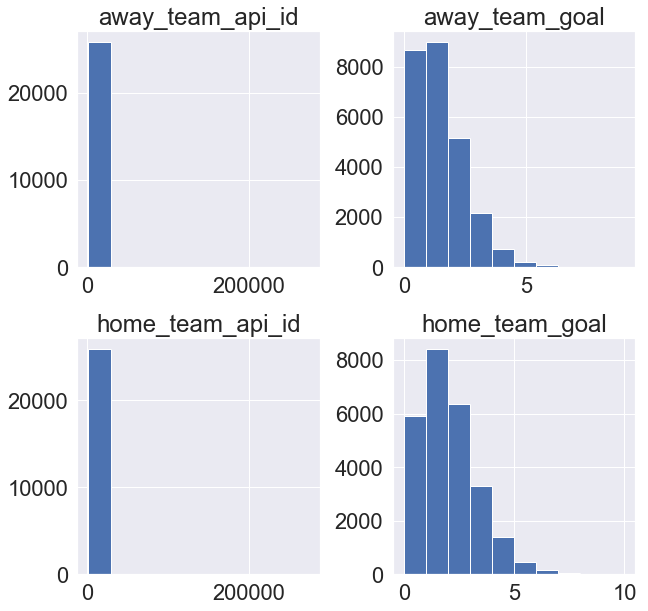

In [503]:
graph = df[['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].hist(figsize=(10,10))

In [504]:
# #will need to use log transformation for goal metrics to be able to conduct T-tests
# graph = np.log(np.isfinite(df[['HomeWin', 'AwayWin']])).hist(figsize=(5,5), bins = 10)
# #This is Boolean! As in the Home or Away win is either True or False. So, I will do a chisquared test instead.
# #These two new columns are defined below

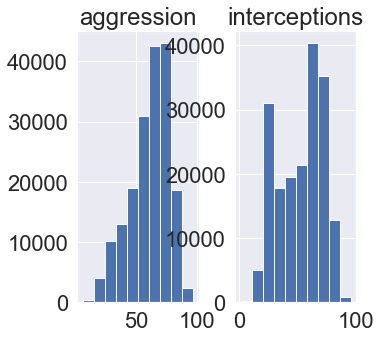

In [505]:
#This is a better candidate for a log transformation
graph = df1[['aggression', 'interceptions']].hist(figsize =(5,5))

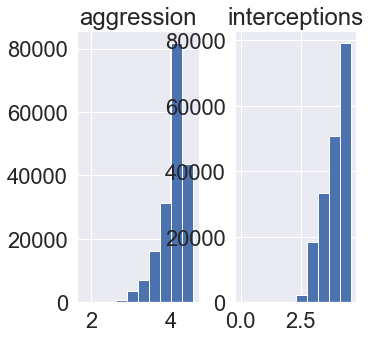

In [506]:
#is this an improvement toward a more normal distribution?
graph = np.log(df1[['aggression', 'interceptions']]).hist(figsize =(5,5))

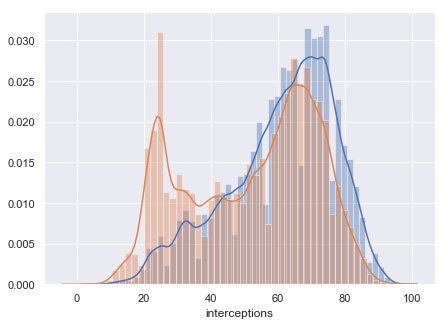

In [507]:
#This overlay shows the correlation is basically what I hypothesize, but with an interesting uptick 
# in low numbers of interceptions
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(7,5)})
sns.distplot(df1.aggression) # Blue distribution
sns.distplot(df1.interceptions) # Orangey distribution

i1 = df1.interceptions[:91989]
i2 = df1.interceptions[91989:]
#Mann-Whitney test here? It tests that the two distributions are the same, and my 
# alternative hypothesis would be that they are not
#Also look into KS test, or a permutation test

In [508]:
A=df1.aggression
I=df1.interceptions

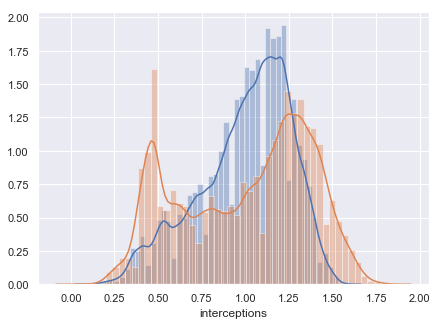

In [509]:
Am = A/A.mean()
Im = I/I.mean()
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(7,5)})
sns.distplot(Am) # Blue distribution
sns.distplot(Im) # Orangey distribution

In [510]:
# sns.set(color_codes=True)
# sns.set(rc={'figure.figsize':(7,5)})
# sns.distplot(binary[0]) # Blue distribution
# sns.distplot(binary[1]) # Orangey distribution

### Create columns for Home/Away/Draw
#### Need to answer this question: Is there a statistical difference in the odds of winning a game when a team is playing in front of their home crowd?

In [511]:
one = ['a','b','c']
two = ['c','d','e']
three = one + two
list(set(three))

['b', 'd', 'c', 'e', 'a']

In [512]:
df

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67
5,6,1,1,2008/2009,1,2008-09-24 00:00:00,492478,8203,8342,1,...,1.67,4.35,3.40,1.70,4.50,3.40,1.70,NaN,NaN,NaN
6,7,1,1,2008/2009,1,2008-08-16 00:00:00,492479,9999,8571,2,...,3.60,2.10,3.25,3.00,1.85,3.25,3.75,2.10,3.25,3.10
7,8,1,1,2008/2009,1,2008-08-16 00:00:00,492480,4049,9996,1,...,2.40,2.80,3.25,2.25,2.80,3.20,2.25,2.88,3.25,2.20
8,9,1,1,2008/2009,1,2008-08-16 00:00:00,492481,10001,9986,1,...,3.10,2.25,3.25,2.80,2.20,3.30,2.80,2.25,3.20,2.80
9,10,1,1,2008/2009,10,2008-11-01 00:00:00,492564,8342,8571,4,...,10.00,1.30,4.35,8.50,1.25,5.00,10.00,1.29,4.50,9.00


# ******** Win Percentage ********



In [513]:
# #(From Joe): Sets up columns to see who won or lost or draw
df['HomeWin']=df.home_team_goal>df.away_team_goal
df['AwayWin']=df.away_team_goal>df.home_team_goal
df['Draw']=df.home_team_goal==df.away_team_goal
# print(len(df['HomeWin']))
# print(len(df['AwayWin']))
# foo = df.groupby(df.home_team_api_id)
# foo2 = foo.groups
# foo3

# df.head()
# foo = df.groupby(df.home_team_api_id)
# x=foo.get_group(1601)
# #Sets up columns to see who won or lost or draw

# win_per = x.HomeWin.sum()/len(x.HomeWin)
# windict = {}

def getwinpercents(df):
    win_dict={}
    #for home wins
    foo_home = df.groupby(df.home_team_api_id) #slice by home id
    foo_away = df.groupby(df.away_team_api_id) #slice by away id
    foo = list(foo_away.groups.keys()) + list(foo_home.groups.keys())
    team_ids = list(set(foo)) #get individual team ids
    #calculate and store home win percentages
    for team in team_ids:
        x=foo_home.get_group(team) #grab home wins
        y=foo_away.get_group(team) #grab away wins
        
        home_per=x.HomeWin.sum()/len(x.HomeWin) #calculate
        away_per=y.AwayWin.sum()/len(y.AwayWin)
        draw_per=(1 - (home_per+away_per)) #seems to give draws as remaining percentages of games 
                                            #not marked as Home/Away wins,  but team5 has -.03% draws, might be
                                            # rounding error
        win_dict[team]=[home_per,away_per,draw_per] #store

        
        
    win_df=pd.DataFrame(win_dict).T
    return win_df

per_df = getwinpercents(df)
per_df['team_api_id'] = per_df.index

per_df.columns = ["Home Win Percentage", "Away Win Percentage", "Draw Percentage", "team_api_id"]
win_per_df = per_df.merge(df_api_names, on = 'team_api_id')
cols = list(win_per_df.columns)

cols = cols[5:3:-1] + cols[0:3]
cols

win_per_df= win_per_df[cols]
win_per_df

#reorder the column to make more sense
# cols = list(df.columns)
# len(cols)
# cols = cols[0:2] + cols[-3:] + cols[2:33]
# df = df[cols]

,team_long_name,team_short_name,Home Win Percentage,Away Win Percentage,Draw Percentage
0,Fortuna Düsseldorf,FDU,0.294118,0.117647,0.588235
1,ES Troyes AC,TRO,0.184211,0.105263,0.710526
2,FC Zürich,ZUR,0.433566,0.405594,0.160839
3,Leicester City,LEI,0.500000,0.394737,0.105263
4,Montpellier Hérault SC,MON,0.533835,0.293233,0.172932
5,KV Mechelen,MEC,0.471698,0.273585,0.254717
6,Hibernian,HIB,0.286957,0.283186,0.429858
7,Aston Villa,AVL,0.296053,0.269737,0.434211
8,VfL Wolfsburg,WOL,0.544118,0.316176,0.139706
9,1. FC Köln,FCK,0.313725,0.274510,0.411765


In [514]:
def homewinbinary(df):
    win_dict={}
    #for home wins
    foo_home = df.groupby(df.home_team_api_id) #slice by home id
    foo_away = df.groupby(df.away_team_api_id) #slice by away id
    team_ids = list(foo.groups.keys()) #get individual team ids
    #calculate and store home win percentages
    for team in team_ids:
        x=foo_home.get_group(team) #grab home wins
        y=foo_away.get_group(team) #grab everything else
        
        home_per=x.HomeWin.sum()/len(x.HomeWin) #calculate Home Wins
        else_per=(1 - home_per) #calculate complement of Home Wins
        
        win_dict[team]=[home_per,else_per] #store

        
        
    win_df=pd.DataFrame(win_dict).T
    return win_df
binary = homewinbinary(df)
binary.head()

AttributeError: 'DataFrame' object has no attribute 'groups'

In [ ]:
#(From Joe)
df.HomeWin.sum()/df.HomeWin.shape[0]

In [ ]:
#The effect size of playing home/away appears to be substantial
df.AwayWin.sum()/df.AwayWin.shape[0]

In [ ]:
df.Draw.sum()/df.Draw.shape[0]

### Trying out different kinds of statistical tests
Look at two metrics associated with the offensive side of the game, interceptions and aggression, and test to see if they are positively correlated within a confidence interval of .05

Do a Chisquared test and some others on HomeWin and AwayWin columns further below

### First start out with a heatmap

In [ ]:
#wins = df[['HomeWin', 'AwayWin', 'Draw']]
#offense = df1[['aggression', 'interceptions']]

In [ ]:
#sns.heatmap(wins.corr(), annot=True, center=0);

In [ ]:
#sns.heatmap(offense.corr(), annot=True, center=0);

# Athletism Vs. Skills


In [515]:
#create a seperate dataframe to compare athletic ability to soccer skills
ath_df = df1
ath_df.dropna(inplace=True)
ath_df.drop_duplicates(subset='player_fifa_api_id', inplace=True)
ath_df.drop_duplicates(subset='player_api_id', inplace=True)


In [516]:
#Here are the athletic abilities we will look at:
ath_list =  ['acceleration','sprint_speed','agility','reactions',
       'balance', 'jumping', 'stamina', 'strength']


In [517]:
#here are the soccer skills we will look at:
skills_list = ath_df.loc[:,'potential': 'sliding_tackle'].drop(['acceleration','sprint_speed','agility','reactions',
       'balance', 'jumping', 'stamina', 'strength','preferred_foot', 
            'attacking_work_rate', 'defensive_work_rate','vision','potential','shot_power','volleys','curve'], axis=1).columns


In [518]:
#Uncomment to check if the loop above is working
#ath_df.loc[ath_df.stamina_bottom_75]['potential'][:10]
#dict_25_75['staminapotential'][1][:10]

In [688]:
#instantiate a dataframe with zeros to hold pvalues
qualities_df = pd.DataFrame(index=[skills_list], columns=[ath_list])
for col in qualities_df.columns:
    qualities_df[col].values[:] = 0


In [520]:
#qualities_df.at['preferred_foot','sprint_speed']= 'foo'
#qualities_df.head()

In [689]:
#This will populate two df's, one of pvalues and one of the difference between means

#function takes in the main_df, a p-values holder df, the percentage desired for split (must be 75, 50, or 25),
#a list of athletic measures and a list of osccer skills
def ath_to_skill_ttest(ath_df, qualities_df, top_percent, ath_list, skills_list):
    
    #setting up empty dictionary
    dict_means = {}
    
    #reset values to zero
    for col in qualities_df.columns:
        qualities_df[col].values[:] = 0
    
    #creating a string with % after the percent
    #this is needed for grabbing values off series.describe()
    top_percent_string = str(top_percent)+'%'
    bottom_percent_string = str(100-top_percent)+'%'
    
    #create columns classifying players into upper and lower groups for each athletic ability
    for ath in ath_list:
        ath_df[ath+'_top'+top_percent_string]=ath_df[ath]>= ath_df[ath].describe()[top_percent_string]
        ath_df[ath+'_bottom'+bottom_percent_string]=ath_df[ath]< ath_df[ath].describe()[top_percent_string]

    #this is a dictionary that hold the 25/75 splits
    dict_skill_split = {}
    for i, ath in enumerate(ath_list):
        for j, skill in enumerate(skills_list):
            
            #Creates a dictionary entry for each ath/skill combo with an array the skill of top quartile of the ath
            #and array of the skill of the bottom 75
            dict_skill_split.update({ath+skill : [ath_df.loc[ath_df[ath+'_top'+top_percent_string]][skill], 
                                           ath_df.loc[ath_df[ath+'_bottom'+bottom_percent_string]][skill]]})
            
            dict_means.update({ath+skill : ath_df.loc[ath_df[ath+'_top'+top_percent_string]][skill].mean()- 
                                           ath_df.loc[ath_df[ath+'_bottom'+bottom_percent_string]][skill].mean()})
                

                                                          
    
#This loops through the qualities to conduct individual one-to-one ttests
    fail_reject_list = []
    reject_list = []
    mean_df = qualities_df.copy()                         
    for a, ath in enumerate(ath_list):
        for s, skill in enumerate(skills_list):
                
                              
                x = dict_skill_split[ath+skill][0] #skill level of top of the ath group
                y = dict_skill_split[ath+skill][1] #skill level of bottom of the ath group
                ttest=stats.ttest_ind(x,y) #two sided ttest
                
                #checking for very small numbers and assigning to zero
                if ttest[1]<float('1.0e-7'):
                    qualities_df.iloc[s, a] = 0.0
                else:
                    qualities_df.iloc[s, a] = ttest[1]
                    
                #checking to see if null hypothesis has been rejected
                if ttest[1] > .05:
                    fail_reject_list.append([ath,skill, dict_skill_split[ath+skill][0].mean(),dict_skill_split[ath+skill][1].mean()])
                    mean_df.iloc[s, a] = dict_means[ath+skill]
                else:
                    reject_list.append([ath,skill, dict_skill_split[ath+skill][0].mean(),dict_skill_split[ath+skill][1].mean()])
                    mean_df.iloc[s, a] = dict_means[ath+skill]
                    
                pvalues_df = qualities_df
    return pvalues_df, mean_df, reject_list, fail_reject_list     

pvalues_df_7525, mean_df_7525, reject_list_7525, fail_reject_list_7525 = ath_to_skill_ttest(ath_df, qualities_df, 75, ath_list, skills_list)

#I was having issues with any earlier dataframe that had been assigned by this function getting reassigned
#every time I ran it so for now I have solved it by forcing pandas to make copies
df_7525 = pvalues_df_7525.copy()
mdf_7525 = mean_df_7525.copy()



In [690]:
pvalues_df_5050, mean_df_5050, reject_list_5050, fail_reject_list_5050 = ath_to_skill_ttest(ath_df, qualities_df, 50, ath_list, skills_list)
df_5050 = pvalues_df_5050.copy()
mdf_5050 = mean_df_5050.copy()




In [691]:
pvalues_df_2575, mean_df_2575, reject_list_2575, fail_reject_list_2575 = ath_to_skill_ttest(ath_df, qualities_df, 25, ath_list, skills_list)
df_2575 = pvalues_df_2575.copy()
mdf_2575 = mean_df_2575.copy()



In [668]:
#conveting values from objects to floats so they can be plotted
df_list = [df_7525, df_5050, df_2575, mdf_7525, mdf_5050, mdf_2575]
for dff in df_list:
    for column in dff.columns:
        dff[column] = pd.to_numeric(dff[column])

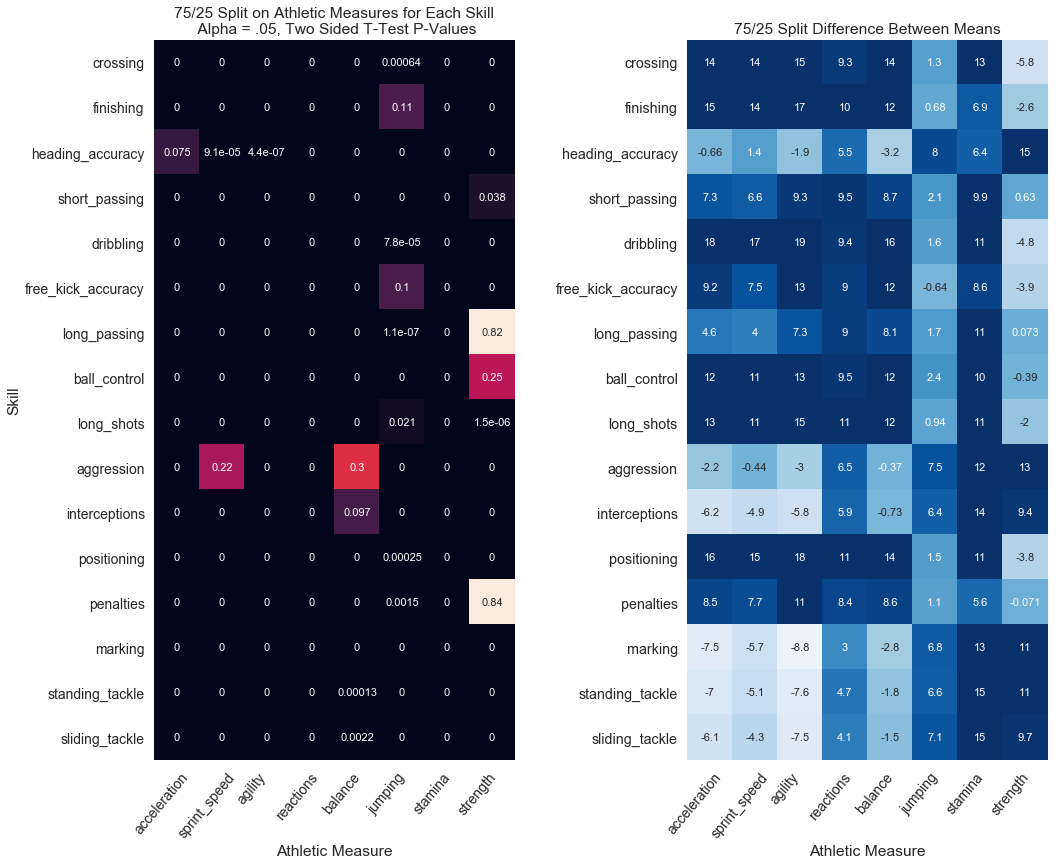

In [684]:
# 75/25 Split Seaborn Heatmap

sns.set(font_scale=1.3)
fig, (ax1, ax2) = plt.subplots(1,2,figsize= (15,20))
sns.heatmap(df_7525, vmin=0, vmax=.53, annot = True, ax = ax1, square = True, annot_kws={"fontsize":11}, cbar= False)
sns.heatmap(mdf_7525, vmin=-10, vmax=10, annot = True, cmap='Blues', ax = ax2, square = True, annot_kws={"fontsize":11}, cbar =False)

#ax.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    tick.label.set_rotation(50)
    
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    tick.label.set_rotation(50)
    
# Create offset transform by 5 points in x direction
dx = -15/72.; dy = 0/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

# apply offset transform to all x ticklabels.
for label in ax1.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
    
for label in ax2.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
    
ax1.set_title("75/25 Split on Athletic Measures for Each Skill\n Alpha = .05, Two Sided T-Test P-Values")
ax2.set_title("75/25 Split Difference Between Means")
ax1.set_ylabel('Skill')    
ax2.set_ylabel(' ')
ax1.set_xlabel('Athletic Measure')
ax2.set_xlabel('Athletic Measure')
fig.tight_layout()

#https://stackoverflow.com/questions/28615887/how-to-move-a-ticks-label-in-matplotlib

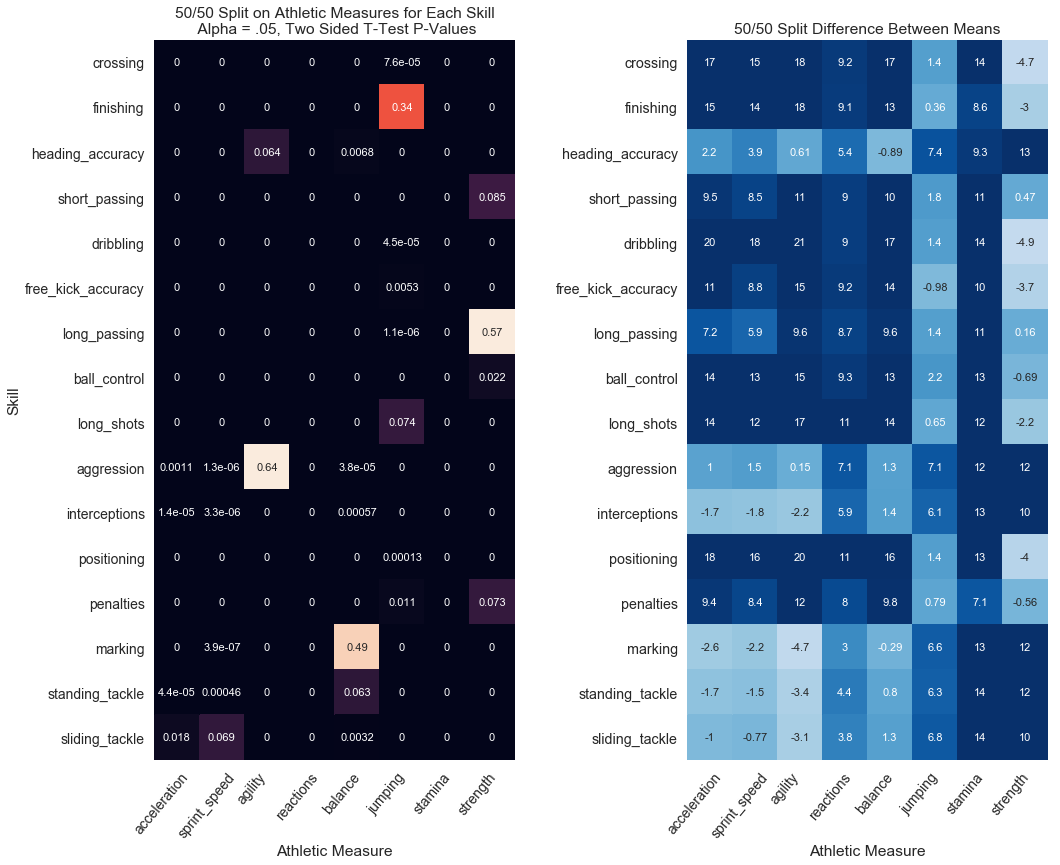

In [686]:
#50/50 Split Seaborn Heatmap

sns.set(font_scale=1.3)
fig, (ax1, ax2) = plt.subplots(1,2,figsize= (15,20))
sns.heatmap(df_5050, vmin=0, vmax=.53, annot = True, ax = ax1, square = True, annot_kws={"fontsize":11}, cbar= False)
sns.heatmap(mdf_5050, vmin=-10, vmax=10, annot = True, cmap='Blues', ax = ax2, square = True, annot_kws={"fontsize":11}, cbar =False)

#ax.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    tick.label.set_rotation(50)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    tick.label.set_rotation(50)
    
# Create offset transform by 5 points in x direction
dx = -15/72.; dy = 0/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

# apply offset transform to all x ticklabels.
for label in ax1.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
    
for label in ax2.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
    
ax1.set_title("50/50 Split on Athletic Measures for Each Skill\n Alpha = .05, Two Sided T-Test P-Values")
ax2.set_title("50/50 Split Difference Between Means")
ax1.set_ylabel('Skill')    
ax2.set_ylabel(' ')
ax1.set_xlabel('Athletic Measure')
ax2.set_xlabel('Athletic Measure')
fig.tight_layout()



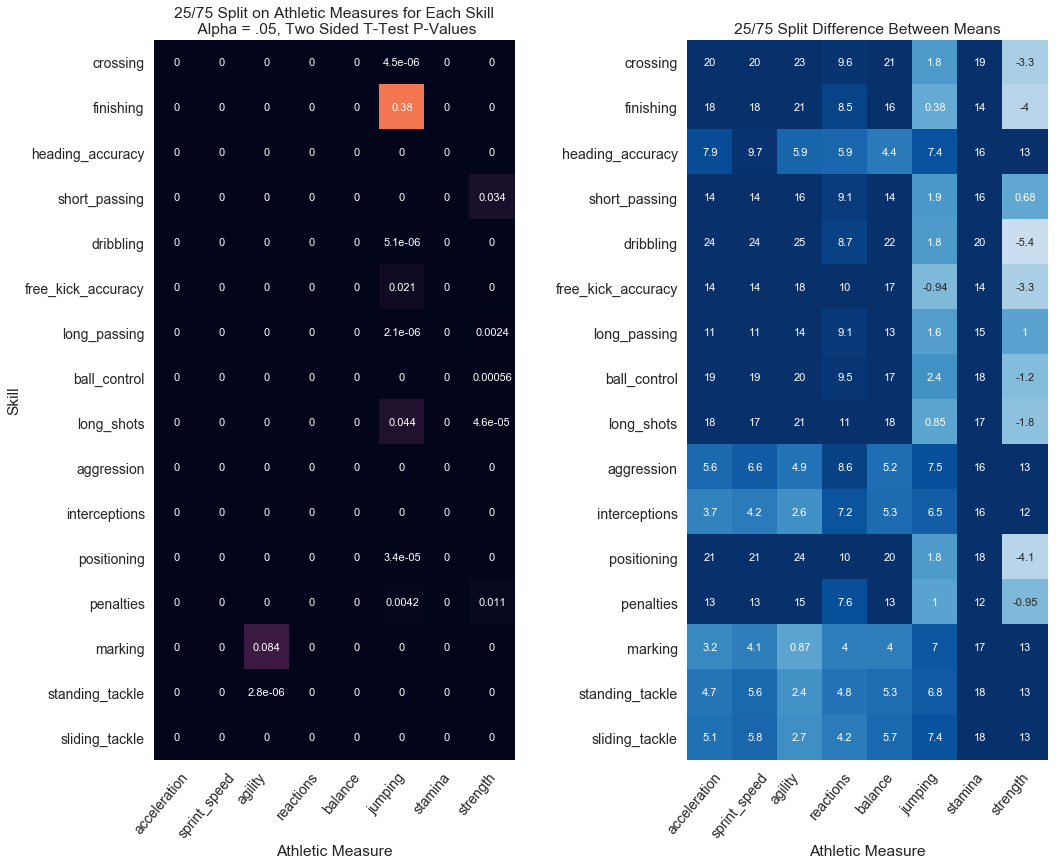

In [687]:
#25/75 Split Seaborn Heatmap

sns.set(font_scale=1.3)
fig, (ax1, ax2) = plt.subplots(1,2,figsize= (15,20))
sns.heatmap(df_2575, vmin=0, vmax=.53, annot = True, ax = ax1, square = True, annot_kws={"fontsize":11}, cbar= False)
sns.heatmap(mdf_2575, vmin=-10, vmax=10, annot = True, cmap='Blues', ax = ax2, square = True, annot_kws={"fontsize":11}, cbar =False)

#ax.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    tick.label.set_rotation(50)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    tick.label.set_rotation(50)
    
# Create offset transform by 5 points in x direction
dx = -15/72.; dy = 0/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

# apply offset transform to all x ticklabels.
for label in ax1.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
    
for label in ax2.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
    
ax1.set_title("25/75 Split on Athletic Measures for Each Skill\n Alpha = .05, Two Sided T-Test P-Values")
ax2.set_title("25/75 Split Difference Between Means")
ax1.set_ylabel('Skill')    
ax2.set_ylabel(' ')
ax1.set_xlabel('Athletic Measure')
ax2.set_xlabel('Athletic Measure')
fig.tight_layout()



# ***********


In [267]:
corr2 = df1.select_dtypes(include =['float64','int64']).\
loc[:,df1.select_dtypes(include =['float64','int64']).columns[3:]].corr()

#Just in coor2 is used later
corr3 = corr2

#Deletes repetive values to improve heatmap visualization
for i in range(corr3.shape[0]):
    for j in range(corr3.shape[1]):
        if j>=i:
            corr3.iloc[i,j] = None

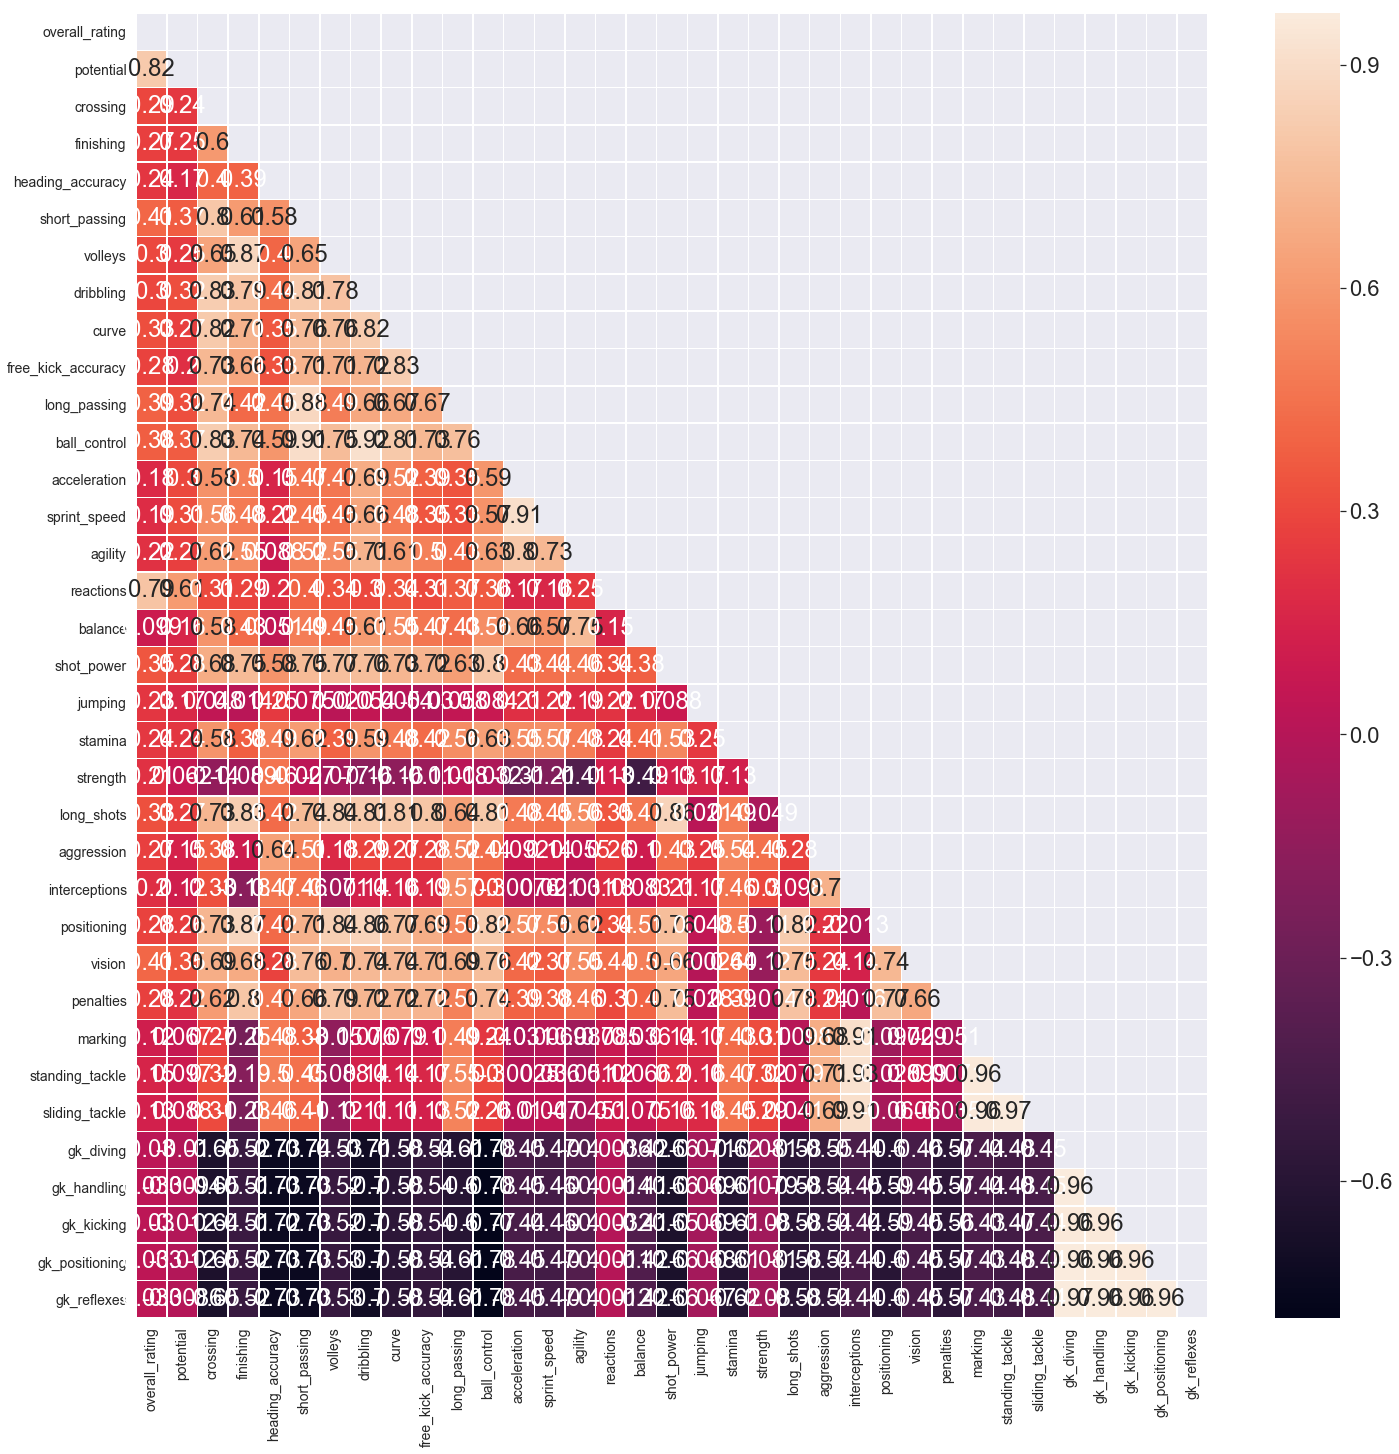

In [268]:
#all player attributes


fig2,ax2 = plt.subplots(nrows = 1,ncols = 1)
fig2.set_size_inches(w=24,h=24)
sns.heatmap(corr3,annot = True,linewidths=0.5,ax = ax2)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    tick.label.set_rotation(90)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)


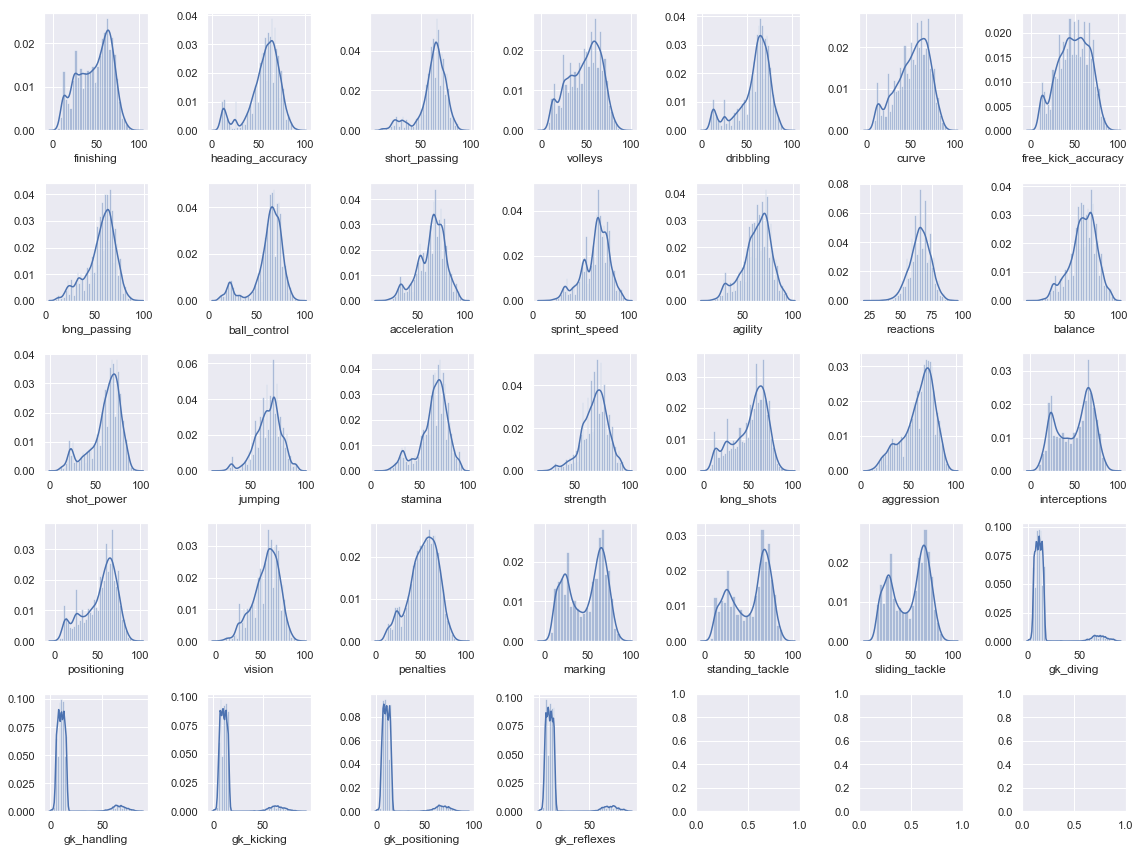

In [355]:
sns.set(font_scale=1)
fig6, ax6 = plt.subplots(nrows=5,ncols=7)
fig6.set_size_inches(16,12)

foo=df1.dropna()
a=foo.select_dtypes(include=['float64']).columns[3:].tolist()
a

i=0
for j in a:
     b = foo[j]
     sns.distplot(b, ax = ax6[int(i/7)][i%7])
     i=i+1
#     len(b)
fig6.tight_layout()

In [270]:
df1.dtypes

id                          int64
player_fifa_api_id          int64
player_api_id               int64
date                       object
overall_rating            float64
potential                 float64
preferred_foot             object
attacking_work_rate        object
defensive_work_rate        object
crossing                  float64
finishing                 float64
heading_accuracy          float64
short_passing             float64
volleys                   float64
dribbling                 float64
curve                     float64
free_kick_accuracy        float64
long_passing              float64
ball_control              float64
acceleration              float64
sprint_speed              float64
agility                   float64
reactions                 float64
balance                   float64
shot_power                float64
jumping                   float64
stamina                   float64
strength                  float64
long_shots                float64
aggression    

In [271]:
array_container_list_top_25_and_bottom_75[-1][1].head(10)

NameError: name 'array_container_list_top_25_and_bottom_75' is not defined

In [ ]:
fig6, ax6 = plt.subplots(nrows=5,ncols=7)
fig6.set_size_inches(16,12)
for i,j in enumerate(df1.select_dtypes(include = ['float64','int64']).columns[3:].tolist()):
    sns.boxplot(x = "interceptions", y = j, data=df1, ax = ax6[int(i/7)][i%7])
fig6.tight_layout()

#### Independent Ttests - don't yield any meaningful insight, with or without log transformation

In [272]:
#https://machinelearningmastery.com/how-to-code-the-students-t-test-from-scratch-in-python/
#https://www.sagepub.com/sites/default/files/upm-binaries/33663_Chapter4.pdf
#consulted these resources for help with statistical helping

#https://www.kaggle.com/efezinoerome/analyzing-soccer-data
#http://www.statstutor.ac.uk/resources/uploaded/tutorsquickguidetostatistics.pdf
#also consulted

In [273]:
ath_df.columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes', 'acceleration_top_25', 'acceleration_bottom_75',
       'sprint_speed_top_25', 'sprint_speed_bottom_75', 'agility_top_25',
       'agility_bottom_75', 'reactions_top_25', 'reactions_bottom_75',
       'balance_top_25', 'balance_bottom_75', 'jumping_top_25',
       'jumping_bottom_75', 'stamina_top_25', 'stamina

In [274]:
#w/out Log Normalization
x = df1.aggression
y = df1.interceptions
ttest=stats.ttest_ind(x,y)
print('t-test independent', ttest)

t-test independent Ttest_indResult(statistic=40.94373273455704, pvalue=0.0)


In [275]:
#w/ Log Normalization
x = np.log(df1.aggression)
y = np.log(df1.interceptions)
ttest=stats.ttest_ind(x,y)
print('t-test independent', ttest)

t-test independent Ttest_indResult(statistic=41.812053622353105, pvalue=0.0)


In [276]:
array_container_list_bottom_75 = []
for column1 in ath_df.loc[:,'stamina_bottom_75': 'strength_bottom_75'].columns:
    for column2 in ath_df.loc[:,'potential': 'sliding_tackle'].columns:
        array_container_list.append(ath_df.loc[ath_df[column1]][column2])
        

NameError: name 'array_container_list' is not defined

In [277]:
# '''
# This is why neither is meaningful here: the population distribution of the aggression and interceptions
# variables are not identical, they do not have identical variances. 

# Calculates the T-test for the means of *two independent* samples of scores.

# This is a two-sided test for the null hypothesis that 2 independent samples
# have identical average (expected) values. This test assumes that the
# populations have identical variances by default.
# '''

#### two and one tailed t-tests on aggression and interceptions

In [278]:
A = df1.aggression
I = df1.interceptions

In [279]:
H = df.HomeWin
Aw = df.AwayWin

In [280]:
#Let's compare means here:
meanA = df1.aggression.mean()
meanI = df1.interceptions.mean()
meanA-meanI

10.377053906024791

In [281]:
print(meanI)

50.67137503603344


In [282]:
print(meanA)

61.04842894205823


In [283]:
# getting standard errors
se1, se2 = sem(df1.aggression), sem(df1.interceptions)

In [284]:
df1.interceptions.std()

20.037059894892792

In [285]:
df1.aggression.std()

16.340509825880922

In [286]:
# standard error on difference between samples
sed = sqrt(se1**2.0 + se2**2.0)

In [287]:
# getting t-statistic
t_stat = (meanA - meanI) / sed
t_stat

40.94373273455704

In [288]:
#degrees of freedom
degf = len(df1.aggression) + len(df1.interceptions) - 2

In [289]:
#critical value, .05
cv = t.ppf(1.0 - .05, degf)
cv

1.6449268461225977

In [290]:
# p-value
p = (1.0 - t.cdf(abs(t_stat), degf)) * 2.0
p

0.0

In [291]:
def independent_ttest(data1, data2, alpha):
	# calculate means
	mean1, mean2 = data1.mean(), data2.mean()
	# calculate standard errors
	se1, se2 = sem(data1), sem(data2)
	# standard error on the difference between the samples
	sed = sqrt(se1**2.0 + se2**2.0)
	# calculate the t statistic
	t_stat = (mean1 - mean2) / sed
	# degrees of freedom
	degf = len(data1) + len(data2) - 2
	# calculate the critical value
	cv = t.ppf(1.0 - alpha, degf)
	# calculate the p-value
	p = (1.0 - t.cdf(abs(t_stat), degf)) * 2.0
	# return everything
	return t_stat, degf, cv, p
 
# seed the random number generator
seed(1)
# generate two independent samples
data1 = 5 * randn(100) + 50
data2 = 5 * randn(100) + 51
# calculate the t test
alpha = 0.05
t_stat, degf, cv, p = independent_ttest(data1, data2, alpha)
print('t=%.3f, df=%d, cv=%.3f, p=%.3f' % (t_stat, degf, cv, p))
# interpret via critical value
if abs(t_stat) <= cv:
	print('Accept null hypothesis that the means are equal.')
else:
	print('Reject the null hypothesis that the means are equal.')
# interpret via p-value
if p > alpha:
	print('Accept null hypothesis that the means are equal.')
else:
	print('Reject the null hypothesis that the means are equal.')

t=-2.262, df=198, cv=1.653, p=0.025
Reject the null hypothesis that the means are equal.
Reject the null hypothesis that the means are equal.


In [292]:
def dependent_ttest(data1, data2, alpha):
	# calculate means
	mean1, mean2 = data1.mean(), data2.mean()
	# number of paired samples
	n = len(data1)
	# sum squared difference between observations
	d1 = sum([(data1[i]-data2[i])**2 for i in range(n)])
	# sum difference between observations
	d2 = sum([data1[i]-data2[i] for i in range(n)])
	# standard deviation of the difference between means
	sd = sqrt((d1 - (d2**2 / n)) / (n - 1))
	# standard error of the difference between the means
	sed = sd / sqrt(n)
	# calculate the t statistic
	t_stat = (mean1 - mean2) / sed
	# degrees of freedom
	degf = n - 1
	# calculate the critical value
	cv = t.ppf(1.0 - alpha, degf)
	# calculate the p-value
	p = (1.0 - t.cdf(abs(t_stat), degf)) * 2.0
	# return everything
	return t_stat, degf, cv, p


# seed the random number generator
seed(1)
# generate two independent samples (pretend they are dependent)
data1 = 5 * randn(100) + 50
data2 = 5 * randn(100) + 51
# calculate the t test
alpha = 0.05
t_stat, degf, cv, p = dependent_ttest(data1, data2, alpha)
print('t=%.3f, df=%d, cv=%.3f, p=%.3f' % (t_stat, degf, cv, p))
# interpret via critical value
if abs(t_stat) <= cv:
	print('Accept null hypothesis that the means are equal.')
else:
	print('Reject the null hypothesis that the means are equal.')
# interpret via p-value
if p > alpha:
	print('Accept null hypothesis that the means are equal.')
else:
	print('Reject the null hypothesis that the means are equal.')

t=-2.372, df=99, cv=1.660, p=0.020
Reject the null hypothesis that the means are equal.
Reject the null hypothesis that the means are equal.


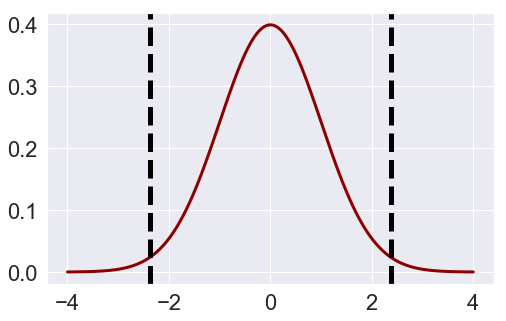

In [293]:
def visualize_t(t_stat, n_control, n_experimental):

    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4,4,500)
    # use stats.t.pdf to get values on the probability density function for the t-distribution
    ys = stats.t.pdf(xs, (n_control+n_experimental)-2, 0, 1)
    # Draw two sided boundary for critical-t
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(t_stat, color='black', linestyle='--', lw=5)
    ax.axvline(-t_stat, color='black', linestyle='--', lw=5)

    plt.show()
    return None

n_cont = len(A)
n_exp = len(I)
visualize_t(t_stat, n_cont, n_exp)

In [294]:
independent_ttest(A, I, .05)

(40.94373273455704, 20812, 1.6449268461225977, 0.0)

In [295]:
independent_ttest(A, i1, .05)

(51.641592997302205, 102394, 1.6448685085169705, 0.0)

In [296]:
independent_ttest(A, i2, .05)

(53.17028739618119, 102394, 1.6448685085169705, 0.0)

In [297]:
dependent_ttest(A, I, .05)

KeyError: 1

In [298]:
independent_ttest(x, y, .05)

(41.812053622353176, 20812, 1.6449268461225977, 0.0)

In [299]:
sns.distplot(binary[0])

NameError: name 'binary' is not defined

In [300]:
sns.distplot(binary[1])

NameError: name 'binary' is not defined

In [301]:
binary.head()

NameError: name 'binary' is not defined

In [302]:
independent_ttest(binary.iloc[:,0], binary.iloc[:,1], .05)

NameError: name 'binary' is not defined

In [303]:
dependent_ttest(binary[0], binary[1], .05)

NameError: name 'binary' is not defined

In [304]:
x = binary[0]
y = binary[1]
ttest=stats.ttest_ind(x,y)
print('T-test independent, one tailed p-value: ', ttest[1])

NameError: name 'binary' is not defined

In [305]:
#This is a single t-test for one comparison between playing at home or not playing at home
x = binary[0]
y = binary[1]
ttest=stats.ttest_ind(x,y)
print('T-test independent, two tailed p-value: ', ttest[1]*2)

NameError: name 'binary' is not defined

In [306]:
x = binary[0]
y = binary[1]
ttest=stats.ttest_ind(A,I)
print('T-test independent, two tailed p-value: ', ttest[1]*2)

NameError: name 'binary' is not defined

In [307]:
x = binary[0]
y = binary[1]
ttest=stats.ttest_ind(A,I)
print('T-test independent, one tailed p-value: ', ttest[1])

NameError: name 'binary' is not defined

In [308]:
ttest=stats.ttest_ind(A,i1)
print('T-test independent, one tailed p-value: ', ttest[1])
print('T-test independent, two tailed p-value: ', ttest[1]*2)

T-test independent, one tailed p-value:  0.0
T-test independent, two tailed p-value:  0.0


In [309]:
ttest=stats.ttest_ind(A,i2)
print('T-test independent, one tailed p-value: ', ttest[1])

T-test independent, one tailed p-value:  0.0


### KS testing aggressive and interceptions

In [310]:
stats.kstest(np.log(A), 'norm')

KstestResult(statistic=0.9945981382063069, pvalue=0.0)

In [311]:
stats.kstest(I, 'norm')

KstestResult(statistic=0.9999999990134123, pvalue=0.0)

In [312]:
stats.kstest(stats.t.rvs(100,A),'norm')

KstestResult(statistic=1.0, pvalue=0.0)

In [313]:
stats.kstest(stats.t.rvs(100,I),'norm')

KstestResult(statistic=0.9999774438879827, pvalue=0.0)

In [314]:
stats.kstest(stats.t.rvs(1,A),'norm')

KstestResult(statistic=0.9943787022732833, pvalue=0.0)

In [315]:
rvs1 = stats.norm.rvs(A, loc=0., scale=1)
rvs2 = stats.norm.rvs(I, loc=0.5, scale=1.5)
stats.ks_2samp(rvs1, rvs2)

TypeError: _parse_args_rvs() got multiple values for argument 'loc'

In [316]:
stats.mannwhitneyu(A,I)

MannwhitneyuResult(statistic=38171394.5, pvalue=5.179302873798109e-298)

In [317]:
stats.mannwhitneyu(A,I,alternative='less')

MannwhitneyuResult(statistic=70134254.5, pvalue=1.0)

In [318]:
stats.mannwhitneyu(x,y,alternative='greater')

MannwhitneyuResult(statistic=70134254.5, pvalue=5.179302873798109e-298)

In [319]:
stats.mannwhitneyu(x,y)

MannwhitneyuResult(statistic=38171394.5, pvalue=5.179302873798109e-298)

In [320]:
stats.mannwhitneyu(A,i1)

MannwhitneyuResult(statistic=353686639.5, pvalue=0.0)

In [321]:
stats.mannwhitneyu(A,i2)

MannwhitneyuResult(statistic=349108547.0, pvalue=0.0)

### permutation testing

In [322]:
A.shape

(10407,)

In [323]:
I.shape

(10407,)

In [324]:
theta_hat = A.mean() - I.mean()
theta_hat

10.377053906024791

In [325]:
#create a function to run your permutation

def run_permutation_test(pooled,sizeZ,sizeY,delta):
    #randomize all the pooled data from arrays y and z
    np.random.shuffle(pooled)
    #grab data the length of z
    starZ = pooled[:sizeZ]
    #grab the rest of the data the length of y
    starY = pooled[-sizeY:]
    #find the difference in the mean
    return starZ.mean() - starY.mean()

In [326]:
#using the full length of dataset breaks this, but using a reduced number of samples always just returns 0

In [327]:
pooled = np.hstack([A,I])
delta = A.mean() - I.mean()
numSamples = 1000
estimates = np.array(list(map(lambda x: run_permutation_test(pooled,A.size,I.size,delta),range(numSamples))))
diffCount = len(np.where(estimates < delta)[0])
hat_sig_perm = 1.0 - (float(diffCount)/float(numSamples))
hat_sig_perm

0.0

In [328]:
from mlxtend.evaluate import permutation_test

p_value = permutation_test(A, I,
                           method='approximate',
                           num_rounds=10000,
                           seed=0)
print(p_value)

ModuleNotFoundError: No module named 'mlxtend'

### Welch's T-test

In [329]:
def welch_t(a, b):
    
    """ Calculate Welch's t statistic for two samples. """

    numerator = a.mean() - b.mean()
    
    # “ddof = Delta Degrees of Freedom”: the divisor used in the calculation is N - ddof, 
    #  where N represents the number of elements. By default ddof is zero.
    
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    
    return np.abs(numerator/denominator)

welch_t(A, I)


40.94373273455709

In [330]:
welch_t(H, Aw)


41.02469141216727

In [331]:
welch_t(binary[0], binary[1])

NameError: name 'binary' is not defined

In [332]:
welch_df(binary[0], binary[1])

NameError: name 'welch_df' is not defined

In [333]:
p = 1 - stats.t.cdf(binary[0], binary[1])
print(p[0:5])

NameError: name 'binary' is not defined

In [334]:
def welch_df(a, b):
    
    """ Calculate the effective degrees of freedom for two samples. """
    
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator

welch_df(A, I)

20002.624836788666

In [335]:
welch_df(H, Aw)

51481.466494684086

In [336]:
# is the t here part of SciPy's stat's model? it would appear to be
p = 1 - stats.t.cdf(A, I)
print(p)

[0. 0. 0. ... 0. 0. 0.]


In [337]:
p = 1 - stats.t.cdf(H, Aw)
print(p)

[nan nan 0.5 ... nan nan nan]


### Effect size and the binomial distribution of interceptions

In [338]:
print(i1.describe())
i2.describe()

count    91989.000000
mean        52.139795
std         19.425996
min          2.000000
25%         34.000000
50%         57.000000
75%         68.000000
max         96.000000
Name: interceptions, dtype: float64


count    91989.000000
mean        51.878748
std         19.384992
min          1.000000
25%         34.000000
50%         56.000000
75%         68.000000
max         96.000000
Name: interceptions, dtype: float64

In [339]:
183978/2

91989.0

In [340]:
I.mean()

50.67137503603344

In [341]:
above = []
below = []
for item in I:
    if item>=I.mean():
        above.append(item)
    else:
        below.append(item)
    
    

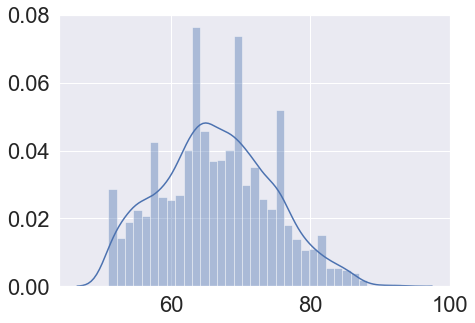

In [342]:
sns.distplot(above)

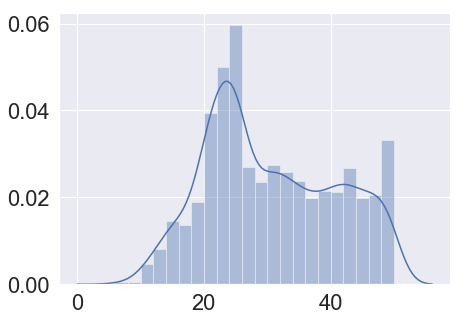

In [343]:
sns.distplot(below)

In [344]:
aggression_binomial = []
for item in df1.aggression:
    if item>=I.mean():
        aggression_binomial.append(1)
    else:
        aggression_binomial.append(0)
        

In [345]:
sum(I_binomial)/len(I_binomial)

NameError: name 'I_binomial' is not defined

In [346]:
stats.binom_test(sum(I_binomial), len(I_binomial), .58, alternative='two-sided')

NameError: name 'I_binomial' is not defined

In [347]:
stats.binom_test(sum(interceptions_binomial), len(interceptions_binomial), .2, alternative='two-sided')

NameError: name 'interceptions_binomial' is not defined

In [348]:
stats.binom_test(sum(aggression_binomial), len(aggression_binomial), .7, alternative='two-sided')

1.1689669809185911e-48

In [349]:
df1.columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes', 'acceleration_top_25', 'acceleration_bottom_75',
       'sprint_speed_top_25', 'sprint_speed_bottom_75', 'agility_top_25',
       'agility_bottom_75', 'reactions_top_25', 'reactions_bottom_75',
       'balance_top_25', 'balance_bottom_75', 'jumping_top_25',
       'jumping_bottom_75', 'stamina_top_25', 'stamina

In [350]:
interceptions_binomial = []
for item in df1.interceptions:
    if item>=I.mean():
        interceptions_binomial.append(1)
    else:
        interceptions_binomial.append(0)
        

In [351]:
independent_ttest(H, Aw, alpha)

(41.02469141216727, 51956, 1.6448829555464886, 0.0)

In [352]:
I_binomial

NameError: name 'I_binomial' is not defined

In [353]:
sns.distplot(I_binomial)

NameError: name 'I_binomial' is not defined